## Data Preprocessing

In [128]:
import os
import numpy as np
from os import listdir
from matplotlib.pyplot import imread
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


# Settings:
img_size = 64
grayscale_images = True
num_class = 10
test_size = 0.2


def get_img(data_path):
    # Getting image array from path:
    img = imread(data_path)
    img = resize(img, (img_size, img_size, 1 if grayscale_images else 3))
    return img


def get_dataset(dataset_path='Dataset'):
    # Getting all data from data path:
    try:
        X = np.load('npy_dataset/X.npy')
        Y = np.load('npy_dataset/Y.npy')
    except:
        labels = ['0','1','2','3','4','5','6','7','8','9']  # Geting labels
        X = []
        Y = []
        for i, label in enumerate(labels):
            datas_path = dataset_path + '/' + label
            for data in listdir(datas_path):
                img = get_img(datas_path + '/' + data)
                X.append(img)
                Y.append(i)
        # Create dateset:
        X = np.array(X).astype('float32')
        Y = np.array(Y).astype('float32')
        Y = to_categorical(Y, num_class)
        if not os.path.exists('npy_dataset/'):
            os.makedirs('npy_dataset/')
        np.save('npy_dataset/X.npy', X)
        np.save('npy_dataset/Y.npy', Y)
    X, X_test, Y, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    return X, X_test, Y, Y_test


X, X_test, Y, Y_test = get_dataset()


## Imports

In [129]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
y = np.argmax(Y, axis=1)
y_test = np.argmax(Y_test, axis=1)
y.shape

(1649,)

In [130]:
def visualize_image_gray(image, label):
    plt.axis('off')
    plt.title(label)
    plt.imshow(image, cmap=plt.cm.binary)

In [131]:
def visualize_image_rgb(image, label):
    plt.axis('off')
    plt.title(label)
    plt.imshow(image)

## Images Visualization

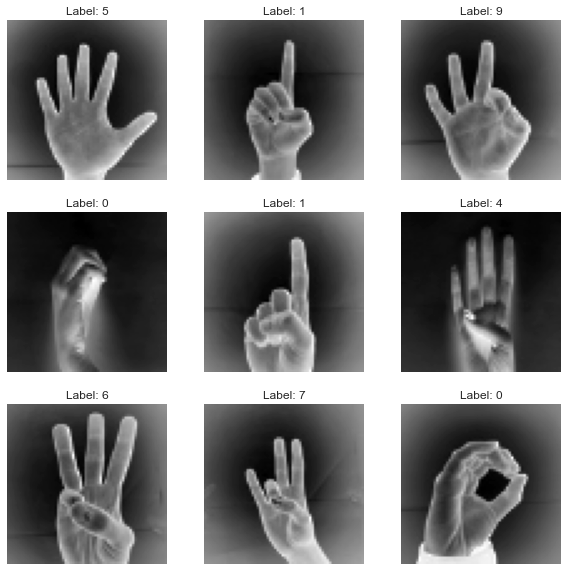

In [132]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    visualize_image_gray(X[i * 100], label="Label: " + str(y[i * 100]))

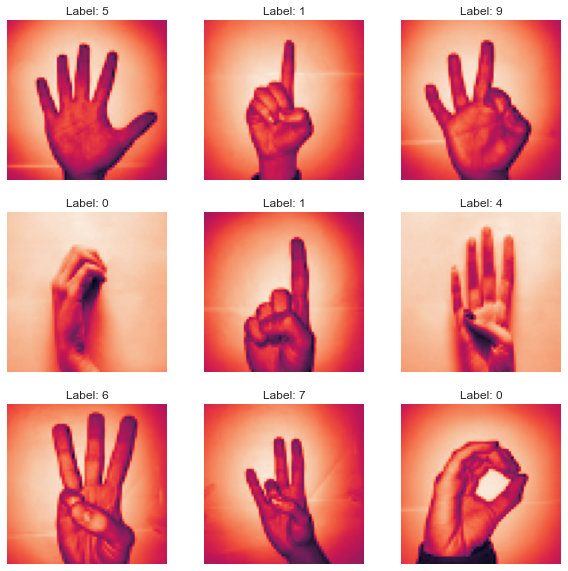

In [133]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    visualize_image_rgb(X[i * 100], label="Label: " + str(y[i * 100]))

## Preparing model

In [134]:
inputs = tf.keras.Input(shape=(64, 64, 1))

conv1 = tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu')(inputs)
pool1 = tf.keras.layers.AveragePooling2D()(conv1)

conv2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu')(pool1)
pool2 = tf.keras.layers.AveragePooling2D()(conv2)

flatten = tf.keras.layers.Flatten()(pool2)

dense1 = tf.keras.layers.Dense(units=120, activation='relu')(flatten)
dense2 = tf.keras.layers.Dense(units=84, activation='relu')(dense1)

outputs = tf.keras.layers.Dense(units=10, activation='softmax')(dense2)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

## Training

In [135]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X,
    y,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
42/42 [==============================] - 2s 30ms/step - loss: 2.3014 - accuracy: 0.1448 - val_loss: 2.2689 - val_accuracy: 0.1545
Epoch 2/100
42/42 [==============================] - 1s 24ms/step - loss: 2.0006 - accuracy: 0.3290 - val_loss: 1.6752 - val_accuracy: 0.4182
Epoch 3/100
42/42 [==============================] - 1s 23ms/step - loss: 1.1192 - accuracy: 0.6361 - val_loss: 1.0529 - val_accuracy: 0.6606
Epoch 4/100
42/42 [==============================] - 1s 22ms/step - loss: 0.7575 - accuracy: 0.7612 - val_loss: 0.8841 - val_accuracy: 0.7030
Epoch 5/100
42/42 [==============================] - 1s 20ms/step - loss: 0.6028 - accuracy: 0.8089 - val_loss: 0.7361 - val_accuracy: 0.7697
Epoch 6/100
42/42 [==============================] - 1s 20ms/step - loss: 0.5074 - accuracy: 0.8446 - val_loss: 0.7150 - val_accuracy: 0.7576
Epoch 7/100
42/42 [==============================] - 1s 21ms/step - loss: 0.4523 - accuracy: 0.8582 - val_loss: 0.6636 - val_accuracy: 0.7727
Epoch 

## Evaluating

In [136]:
def evaluate_model(model, X_test, y_test):
    
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    cm = confusion_matrix(y_test, y_pred)
    clr = classification_report(y_test, y_pred)
    
    results = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

13/13 [==============================] - 0s 8ms/step
Test Loss: 0.72350
Test Accuracy: 81.36%


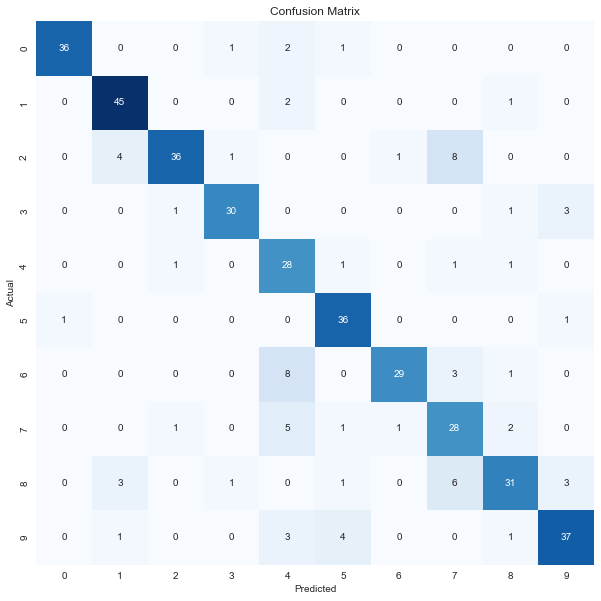

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.97      0.90      0.94        40
           1       0.85      0.94      0.89        48
           2       0.92      0.72      0.81        50
           3       0.91      0.86      0.88        35
           4       0.58      0.88      0.70        32
           5       0.82      0.95      0.88        38
           6       0.94      0.71      0.81        41
           7       0.61      0.74      0.67        38
           8       0.82      0.69      0.75        45
           9       0.84      0.80      0.82        46

    accuracy                           0.81       413
   macro avg       0.83      0.82      0.81       413
weighted avg       0.83      0.81      0.82       413



In [137]:
evaluate_model(model, X_test, y_test)

In [138]:
y_pred = np.argmax(model.predict(X_test), axis=1)
pred = model.predict(X_test)

13/13 [==============================] - 0s 6ms/step


In [139]:
pred[0]

array([8.5556928e-07, 4.4222645e-08, 5.8822332e-07, 4.5615679e-06,
       9.5693672e-01, 8.1943092e-04, 4.8646194e-04, 2.0210918e-02,
       2.0786412e-02, 7.5378624e-04], dtype=float32)

# ANN

In [140]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2 , random_state = 42)
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_class, activation=tf.nn.softmax)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model1.fit(X, Y, batch_size=32, validation_data=[X_val, Y_val], epochs=30, callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True
        )
    ])

Epoch 1/30
52/52 [==============================] - 2s 22ms/step - loss: 2.8502 - accuracy: 0.1055 - val_loss: 2.2983 - val_accuracy: 0.1061
Epoch 2/30
52/52 [==============================] - 1s 22ms/step - loss: 2.2986 - accuracy: 0.1079 - val_loss: 2.2853 - val_accuracy: 0.1091
Epoch 3/30
52/52 [==============================] - 1s 25ms/step - loss: 2.2915 - accuracy: 0.1128 - val_loss: 2.3032 - val_accuracy: 0.1030
Epoch 4/30
52/52 [==============================] - 1s 22ms/step - loss: 2.2845 - accuracy: 0.1225 - val_loss: 2.2440 - val_accuracy: 0.1182
Epoch 5/30
52/52 [==============================] - 1s 24ms/step - loss: 2.2263 - accuracy: 0.1358 - val_loss: 2.2214 - val_accuracy: 0.1788
Epoch 6/30
52/52 [==============================] - 1s 22ms/step - loss: 2.2401 - accuracy: 0.1461 - val_loss: 2.2113 - val_accuracy: 0.1758
Epoch 7/30
52/52 [==============================] - 1s 25ms/step - loss: 2.2193 - accuracy: 0.1534 - val_loss: 2.1858 - val_accuracy: 0.1848
Epoch 8/30
52

In [141]:
score = model1.evaluate(X_test, Y_test)
print('Loss: {:.4f}  Accuaracy: {:.4}%'.format(score[0],score[1]))

13/13 [==============================] - 0s 3ms/step - loss: 2.1056 - accuracy: 0.1768
Loss: 2.1056  Accuaracy: 0.1768%
